In [71]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal

# !pip install pint
from pint import UnitRegistry
units = UnitRegistry(system = "mks")
units.default_format = "~P.2e"

### Constants and parameters

In [72]:
mu_0 = 1 * units.vacuum_permeability
N = 10000
l = 18 * units.millimeter
R = 34 * units.millimeter / 2
I_original = 1 * units.amp
magnet_dipole = 0.0369 * 100 * units.amp * units.meter ** 2
z_space = np.linspace(0 * units.mm, 100 * units.mm, 1000)
m = 8.37 * units.gram
g = 1 * units.standard_gravity
res = 1 * units.ohm
Fg = m * g

### B field equations
![B field equations](images/B_field_equations.png)
![F equations](images/F_equation.png)
![Lorenz equations](images/Lorenz_equation.png)

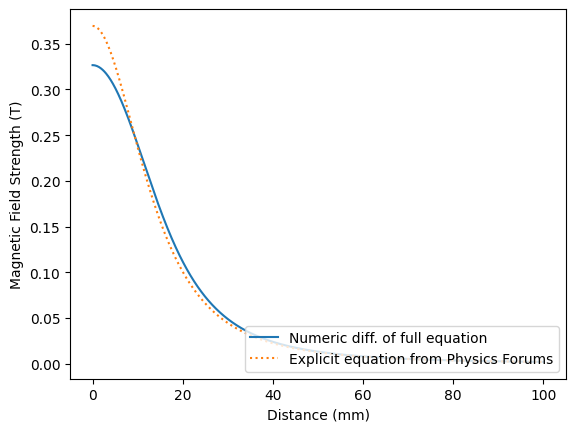

In [73]:
class AccurateModel:
    @classmethod
    def get_B_z_axis(cls, z, I):
        B_z_axis = mu_0 * N * I / 2 * (((l / 2 - z) / (l * np.sqrt(R ** 2 + (l / 2 - z) ** 2))) + ((l / 2 + z) / (l * np.sqrt(R ** 2 + (l / 2 + z) ** 2))))
        return B_z_axis
    @classmethod
    def get_F_z_axis(cls, z, I):
        dz = 0.05 * units.mm
        zs = np.linspace(z - dz, z + dz, 2)
        B_z_axis = cls.get_B_z_axis(zs, I)
        dBdz = (B_z_axis[1] - B_z_axis[0]) / dz
        F_z_axis = magnet_dipole * dBdz
        return F_z_axis
    @classmethod
    def get_F_z_axis_as_vector(cls, z, I):
        F_z_axis = np.zeros(np.size(z)) * units.newton
        for idx, z_val in enumerate(z):
            F_z_axis[idx] = cls.get_F_z_axis(z_val, I)
        return F_z_axis
    @classmethod
    def get_lorenz_force(cls, z, dzdt):
        Fl = N * -9 * mu_0 ** 2 * magnet_dipole ** 2 * R ** 4 * z ** 2 * dzdt / (4 * res * (R ** 2 + z ** 2) ** 5)
        return Fl
    @classmethod
    def get_gravity_force(cls):
        Fg = m * g
        return Fg

class ShortSolenoidModel:
    @classmethod
    def get_B_z_axis(cls, z, I):
        B_short_solenoid_eq = mu_0 * I * N * R ** 2 / (2 * (R ** 2 + z ** 2) ** (3 / 2)) # From wikipedia: https://en.wikipedia.org/wiki/Solenoid#Short_solenoid_estimate
        return B_short_solenoid_eq
    @classmethod
    def get_F_z_axis(cls, z, I):
        F_short_solenoid_eq = -3 * mu_0 * R ** 2 * N * I * z / (2 * (R ** 2 + z ** 2) ** (5 / 2)) * magnet_dipole # From: https://www.physicsforums.com/insights/how-to-model-a-magnet-falling-through-a-conducting-pipe/
        return F_short_solenoid_eq

B_z_axis = AccurateModel.get_B_z_axis(z_space, I_original)
F_z_axis = AccurateModel.get_F_z_axis_as_vector(z_space, I_original)
B_short_solenoid_eq = ShortSolenoidModel.get_B_z_axis(z_space, I_original)
F_short_solenoid_eq = ShortSolenoidModel.get_F_z_axis(z_space, I_original)

plt.plot(z_space.to(units.mm), B_z_axis.to(units.tesla), label = "Numeric diff. of full equation")
plt.plot(z_space.to(units.mm), B_short_solenoid_eq.to(units.tesla), linestyle = "dotted", label = "Explicit equation from Physics Forums")
plt.xlabel("Distance (mm)")
plt.ylabel("Magnetic Field Strength (T)")
plt.legend(loc = "lower right")

### Linearizing the force

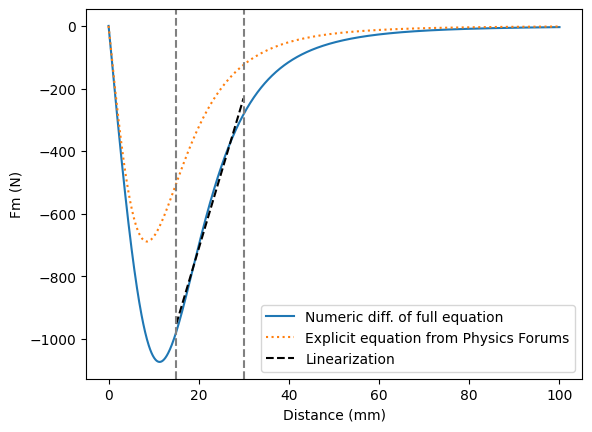

In [74]:
def linreg(x, y):
    A = np.vstack([x.magnitude, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y.magnitude, rcond=None)[0]
    slope = slope * y.units / x.units
    intercept = intercept * y.units
    return slope, intercept

def linreg_points(x, y, start_lin_reg, end_lin_reg):
    lin_reg_range = (start_lin_reg <= x) & (x <= end_lin_reg)
    new_x = x[lin_reg_range]
    new_y = y[lin_reg_range]
    slope, intercept = linreg(new_x, new_y)
    return slope, intercept, new_x, new_x * slope + intercept

start_lin_reg = 15 * units.mm
end_lin_reg = 30 * units.mm
lin_reg_range = (start_lin_reg <= z_space) & (z_space <= end_lin_reg)
dFdz_at_original_I, F_intercept_at_original_I, z_lin_reg, Fm_lin_reg = linreg_points(z_space, F_z_axis, start_lin_reg, end_lin_reg)

plt.plot(z_space.to(units.mm), F_z_axis.to(units.newton), label = "Numeric diff. of full equation")
plt.plot(z_space.to(units.mm), F_short_solenoid_eq.to(units.newton), linestyle = "dotted", label = "Explicit equation from Physics Forums")
plt.plot(z_lin_reg.to(units.mm), Fm_lin_reg.to(units.newton), linestyle = "dashed", color = "black", label = "Linearization")
plt.xlabel("Distance (mm)")
plt.ylabel("Fm (N)")
plt.axvline(x = start_lin_reg.to(units.mm).magnitude, color = "grey", linestyle = "dashed")
plt.axvline(x = end_lin_reg.to(units.mm).magnitude, color = "grey", linestyle = "dashed")
plt.legend(loc = "lower right")

### Calculating Z0 and I0

In [75]:
z0 = 20 * units.mm

Fm_at_z0_given_original_I = AccurateModel.get_F_z_axis(z0, I_original)
print(f"Force at z = z0 = {z0.to(units.mm)} given an original current of {I_original.to(units.amp)} is {Fm_at_z0_given_original_I.to(units.newton)}")
I0 = Fg / -Fm_at_z0_given_original_I * I_original
print(f"Current must be set to {I0.to(units.amp)} to achieve steady-state with a gravitational force of {Fg.to(units.N)}")

F_z_axis_at_I0 = AccurateModel.get_F_z_axis_as_vector(z_space, I0)
dFdz_at_I0, F_intercept_at_I0, z_lin_reg, Fm_lin_reg = linreg_points(z_space, F_z_axis_at_I0, start_lin_reg, end_lin_reg)

unit_dzdt = 1 * units.mm / units.s
b = -AccurateModel.get_lorenz_force(z0, unit_dzdt) / unit_dzdt
a = dFdz_at_I0
Fm0 = Fm_at_z0_given_original_I / I_original
print(f"dFdz = {a.to(units.newton / units.mm)}")
print(f"dFdv = {b.to(units.newton / (units.mm / units.second))}")

Force at z = z0 = 2.00×10¹ mm given an original current of 1.00×10⁰ A is -7.01e+02 N
Current must be set to 1.17×10⁻⁴ A to achieve steady-state with a gravitational force of 8.21×10⁻² N
dFdz = 5.66×10⁻³ N/mm
dFdv = 1.04×10⁻² N·s/mm


### Controller

$m \ddot{z} + b \dot{z} - a (z - z_0) = F_{m0} (I - I_0)$
Transfer function $G(s) = \frac{(z - z_0)(s)}{(I - I_0)(s)} = \frac{F_{m0}}{m s^2 + b s - a}$
Poles at $\frac{-b \pm \sqrt{(b^2 + 4 m a)}}{2m}$

In [76]:
print(f"b = {b.to(units.newton / (units.m / units.s))}")
print(f"m = {m.to(units.kg)}")
print(f"a = {a.to(units.newton / units.m)}")
print(f"Fm0 = {Fm0.to(units.newton / units.amp)}")
poles = [((-b + np.sqrt(b ** 2 + 4 * m * a)) / (2 * m)).to(1 / units.s), ((-b - np.sqrt(b ** 2 + 4 * m * a)) / (2 * m)).to(1 / units.s)]
print(poles)

def between(minimum, maximum, val):
    if val < minimum:
        return minimum
    if val > maximum:
        return maximum
    return val

def controller(Δz, dΔzdt):
    ΔI = between(-0.2 * units.amp, 0.2 * units.amp, 0.4 / 1000 * units.amp / units.mm * Δz + 6 / 400 / 1000 * units.amp / (units.mm / units.s) * dΔzdt)
    return ΔI

b = 1.04×10¹ N·s/m
m = 8.37×10⁻³ kg
a = 5.66×10⁰ N/m
Fm0 = -7.01e+02 N/A
[<Quantity(0.543976823, '1 / second')>, <Quantity(-1244.16796, '1 / second')>]


### Difference Equation (try # 2)

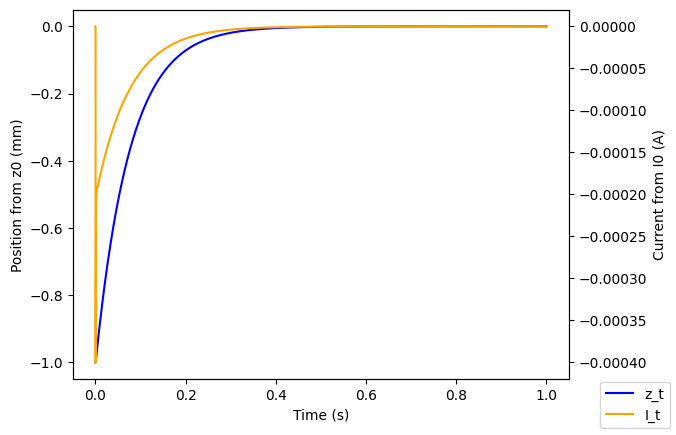

In [77]:
ts = np.linspace(0 * units.second, 1 * units.second, 5000)
dt = np.mean(np.diff(ts))
Δz_t = np.zeros(np.size(ts)) * units.mm
ΔI_t = np.zeros(np.size(ts)) * units.amp
dzdt0 = 0 * units.mm / units.s
for n, t in enumerate(ts, start = 0):
    if n == 0:
        Δz_t[n] = -1 * units.mm
    elif n == 1:
        Δz_t[n] = Δz_t[0] + dzdt0 * dt
    elif abs(Δz_t[n - 1]) > 100 * units.mm:
        break
    else:
        # ΔI_t[n] = 0.0735 * units.amp / units.mm * Δz_t[n - 1]
        ΔI_t[n] = controller(Δz_t[n - 1], (Δz_t[n - 1] - Δz_t[n - 2]) / dt)
        Δz_t[n] = (ΔI_t[n] * Fm0 + m / dt ** 2 * (2 * Δz_t[n - 1] - Δz_t[n - 2]) + b / dt * (Δz_t[n - 1])) / (m / dt ** 2 + b / dt - a)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.plot(ts, ΔI_t.to(units.amp), color = "orange", label = "I_t")
ax1.plot(ts, Δz_t.to(units.mm), color = "blue", label = "z_t")
ax1.set_xlabel("Time (s)")
ax2.set_ylabel("Current from I0 (A)")
ax1.set_ylabel("Position from z0 (mm)")
fig.legend(loc = "lower right")

### Physical model
Warning: overwriting the variables `z_t` and `I_t`

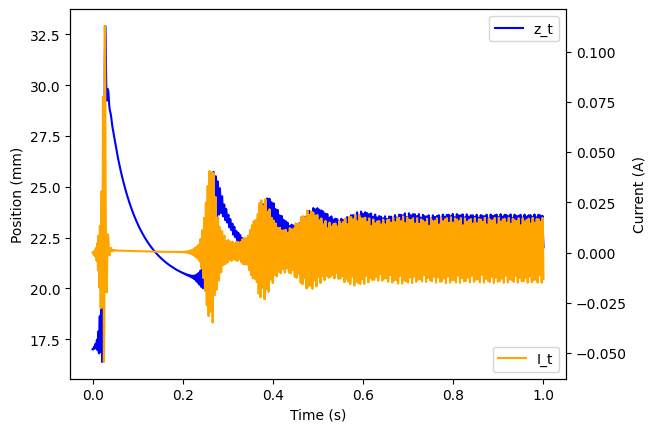

In [78]:
ts = np.linspace(0 * units.second, 1 * units.second, 1000)
dt = np.mean(np.diff(ts))
z_t =    np.zeros(np.size(ts)) * units.mm
dzdt =   np.zeros(np.size(ts)) * units.mm / units.s
d2zdt2 = np.zeros(np.size(ts)) * units.mm / units.s ** 2
I_t = np.zeros(np.size(ts)) * units.amp
dzdt0 = 0 * units.mm / units.s
for n, t in enumerate(ts, start = 0):
    if n == 0:
        z_t[n] = z0 - 3 * units.mm
        I_t[n] = I0
    elif n == 1:
        z_t[n] = z_t[0] + dzdt0 * dt
        I_t[n] = I0
    elif abs(z_t[n - 1]) > 100 * units.mm:
        break
    else:
        # controller
        # I_t[n] = I0 + 1 * units.amp / units.mm * (z_t[n - 1] - z0)# + 0.1 * units.amp / units.mm * units.second * dzdt[n - 1]
        # I_t[n] = I0 + 0.1 * units.amp / units.mm * (z_t[n - 1] - z0)
        I_t[n] = I0 + controller(z_t[n - 1] - z0, (z_t[n - 1] - z_t[n - 2]) / dt)
        # force equations
        Fm = AccurateModel.get_F_z_axis(z_t[n - 1], I_t[n - 1])
        Fl = AccurateModel.get_lorenz_force(z_t[n - 1], dzdt[n - 1])
        Fg = AccurateModel.get_gravity_force()
        Fnet = Fm + Fl + Fg
        d2zdt2[n] = Fnet / m
        dzdt[n] = dzdt[n - 1] + d2zdt2[n] * dt
        z_t[n] = z_t[n - 1] + dzdt[n] * dt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ts, z_t.to(units.mm), color = "blue", label = "z_t")
ax2.plot(ts, I_t.to(units.amp), color = "orange", label = "I_t")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Position (mm)")
ax2.set_ylabel("Current (A)")
ax1.legend(loc = "upper right")
ax2.legend(loc = "lower right")